# **IMPORTS**

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
np.random.seed(3)

In [102]:
EMG_file_name = './Dataset1_DB1/s2/S2_A1_E1.mat'
data = loadmat(EMG_file_name)
print(f"What are the keys of the data structure? {[key for key in data.keys()]}")
emg = data["emg"].copy()
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


# **SUBJECT 2 DATA CHECKING**

In [103]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


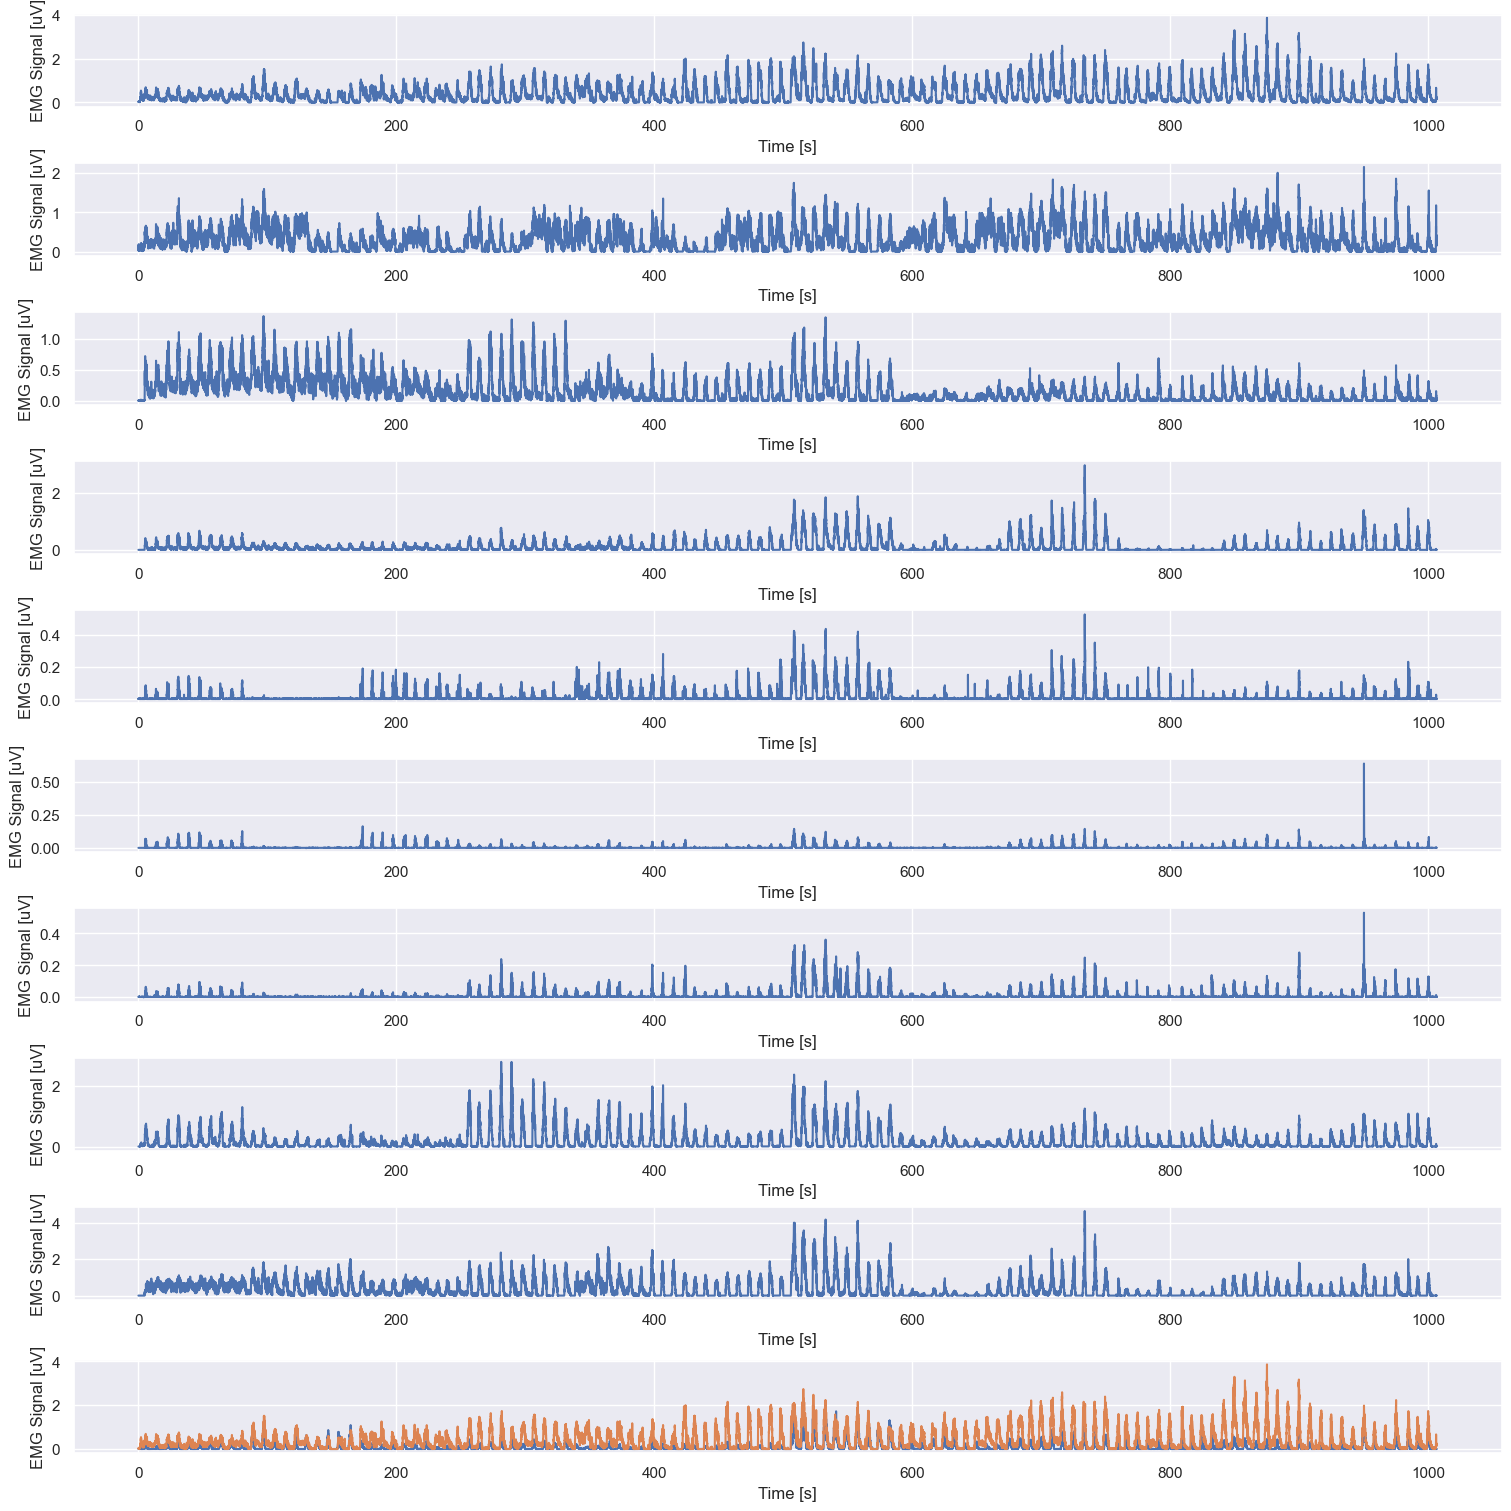

In [108]:
fs = 100
n_channels = emg.shape[1]

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")
    


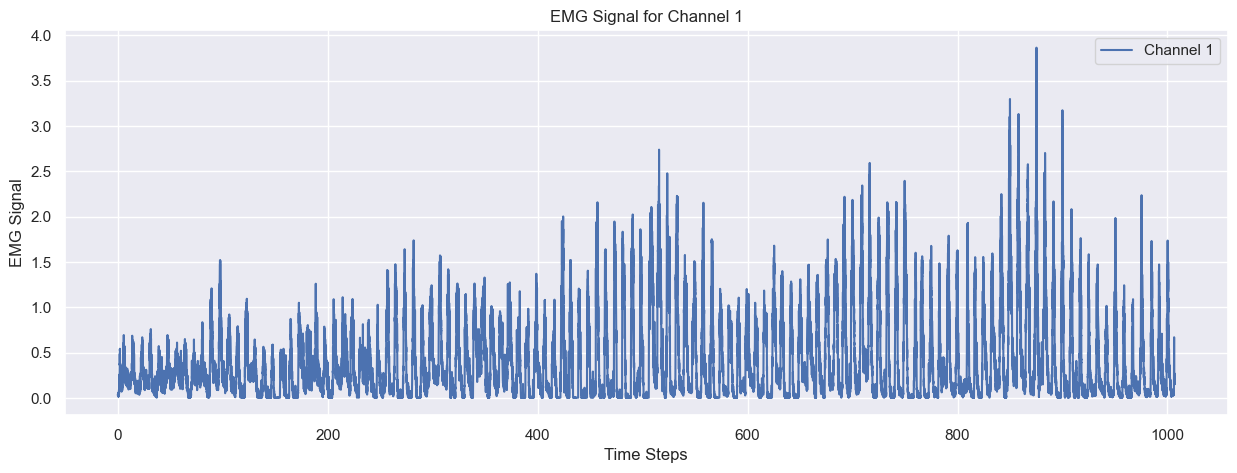

In [110]:
fig, ax = plt.subplots(figsize=(15, 5))  # Create a single subplot with appropriate size

# Plot the EMG signal
ax.plot(time_steps, emg[:, 0], label="Channel 1")  # Label for the plot
ax.set_xlabel("Time Steps")  # Label for x-axis
ax.set_ylabel("EMG Signal")  # Label for y-axis
ax.set_title("EMG Signal for Channel 1")  # Title for the plot
ax.legend()  # Display the legend

# Display the plot
plt.show()

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

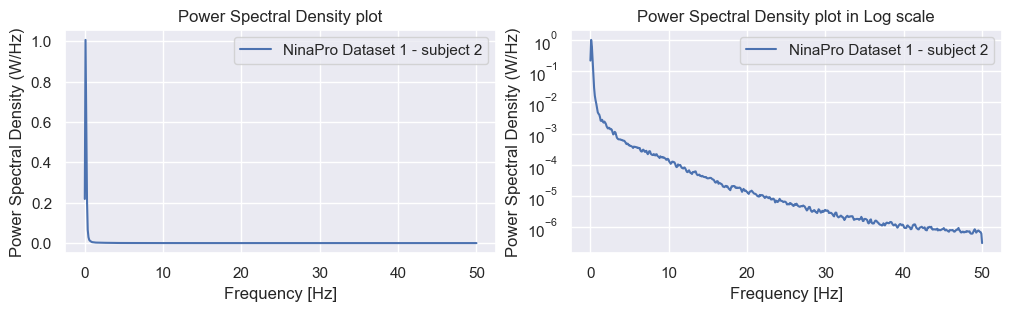

In [64]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)


fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="NinaPro Dataset 1 - subject 2")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="NinaPro Dataset 1 - subject 2")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

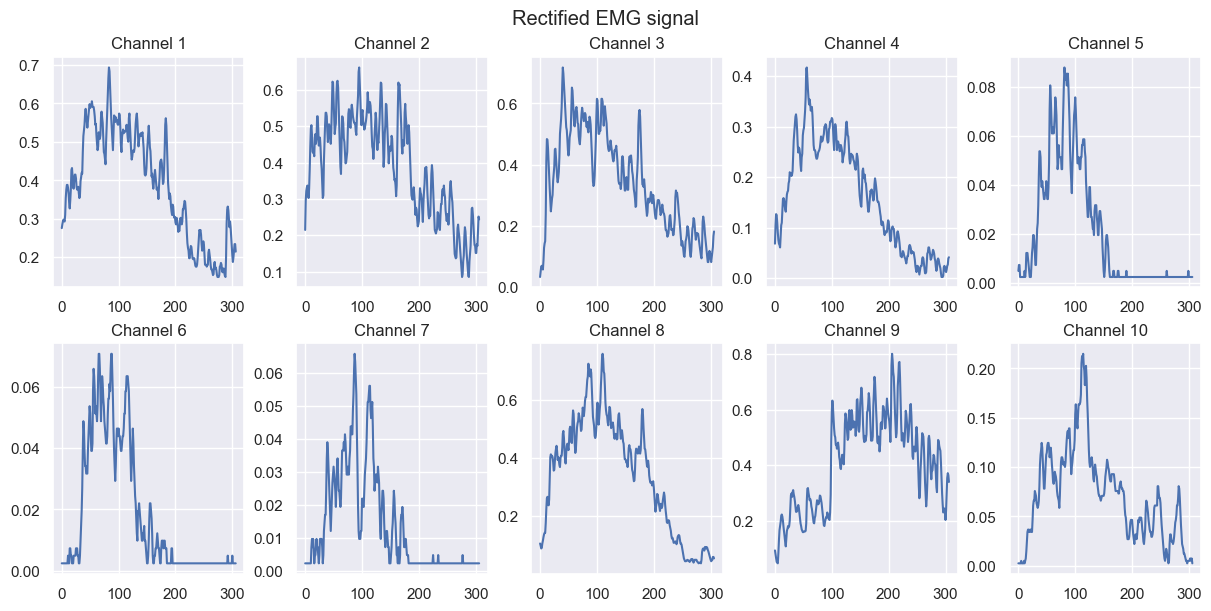

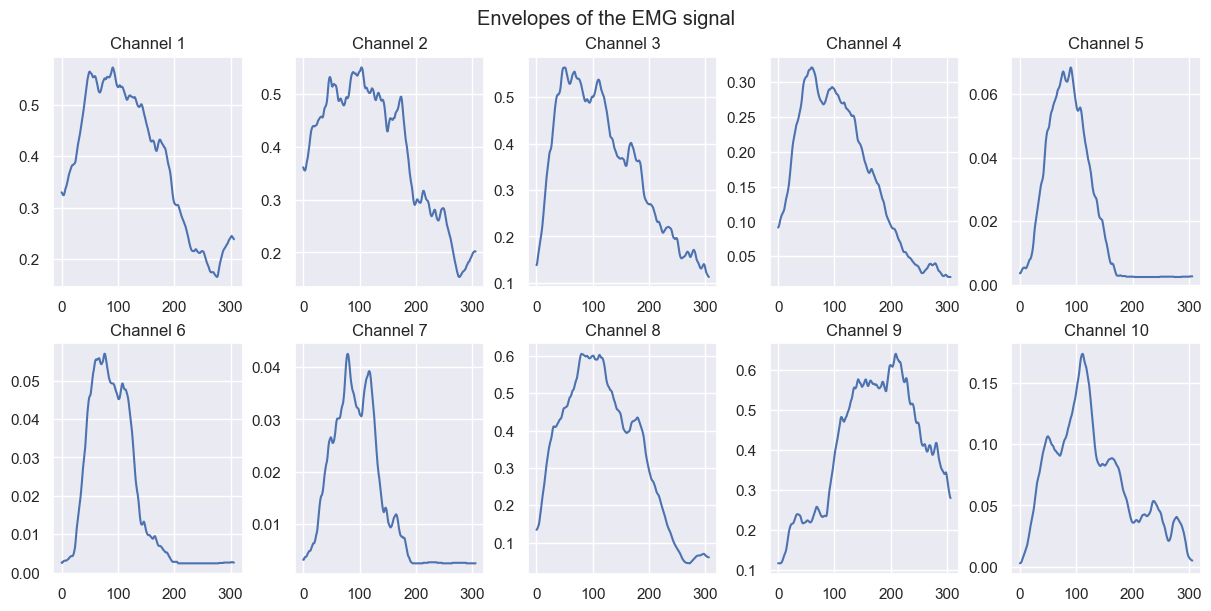

In [65]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 
        
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")


# for repetition_idx in range(n_repetitions):
#     fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
#     ax = ax.ravel()
#     for channel_idx in range(number_of_emg_channels):
#         ax[channel_idx].plot(emg_windows[0][repetition_idx][:, channel_idx])
#         ax[channel_idx].set_title(f"Channel {channel_idx+1} - Rep {repetition_idx+1}")
#     plt.suptitle(f"Rectified EMG Signal for Repetition {repetition_idx+1}")



Text(0.5, 0.98, 'Envelopes of the EMG signal - Individual Y-scale')

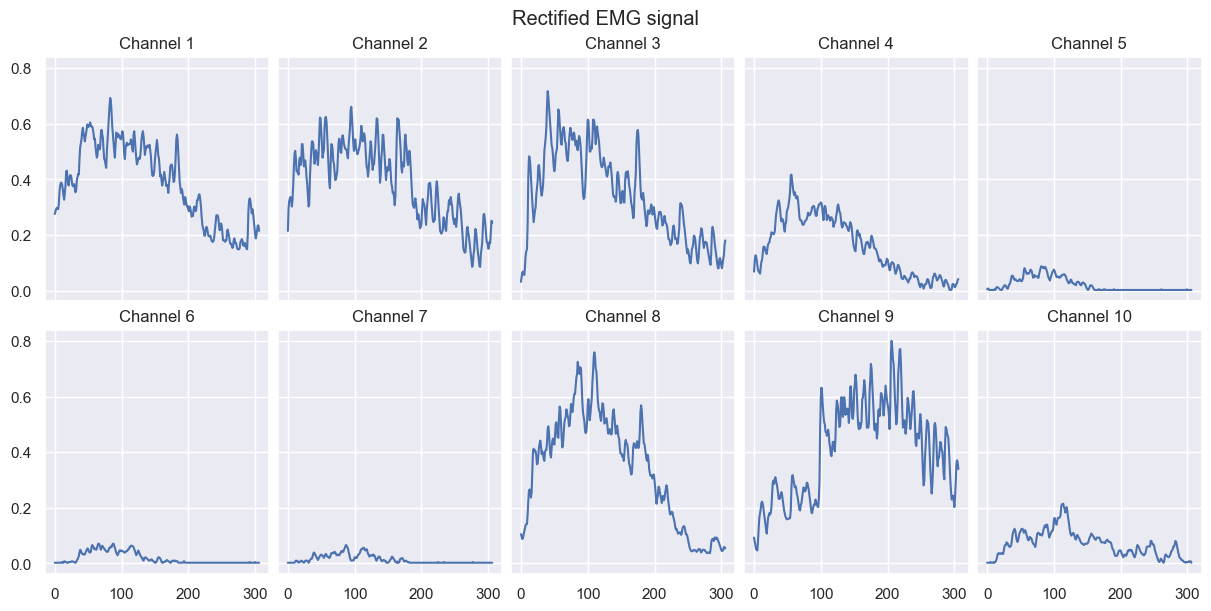

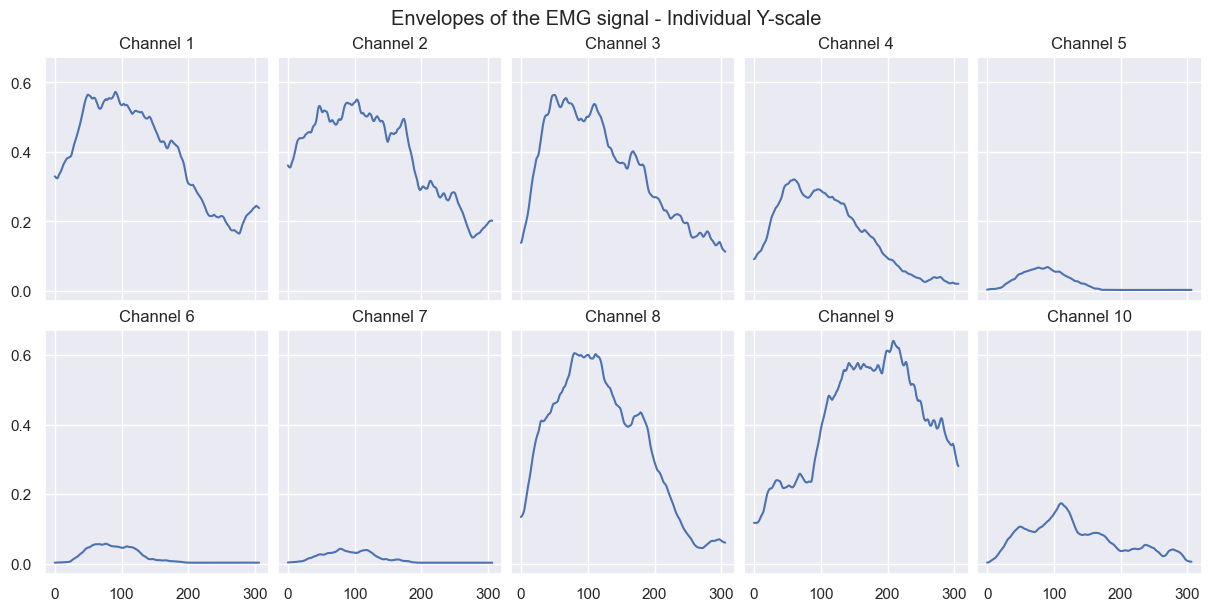

In [66]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal - Individual Y-scale")

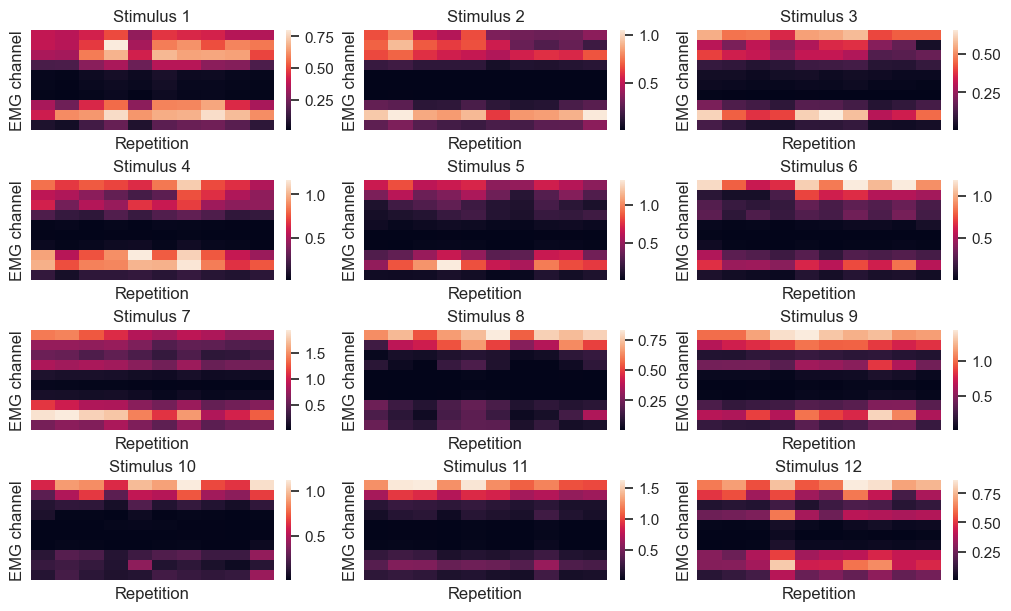

In [67]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

# **CLASSIFICATION : SVM**

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


seed = np.random.seed(3)

In [69]:
EMG_file_name = './Dataset1_DB1/s2/S2_A1_E1.mat'
data = loadmat(EMG_file_name)
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)
        
print("")
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>


# **USEFULL TRAINING FUNCTIONS**

In [71]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

# **FEATURE EXTRACTION**

In [72]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


dataset dimension: (120, 60)
labels dimension: (120,)


In [73]:

n_stimuli = 12  
n_repetitions = 10 
n_channels = emg.shape[1] 
feature_names = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"] 
row_indices = [f"Movement {i+1} - Repetition {j+1}" 
               for i in range(n_stimuli) for j in range(n_repetitions)]
column_indices = [f"Channel {ch+1} - {feat}" 
                  for feat in feature_names for ch in range(n_channels)]

df = pd.DataFrame(dataset, index=row_indices, columns=column_indices)
df["Label"] = labels

df.head()

,Channel 1 - MAV,Channel 2 - MAV,Channel 3 - MAV,Channel 4 - MAV,Channel 5 - MAV,Channel 6 - MAV,Channel 7 - MAV,Channel 8 - MAV,Channel 9 - MAV,Channel 10 - MAV,...,Channel 2 - SSC,Channel 3 - SSC,Channel 4 - SSC,Channel 5 - SSC,Channel 6 - SSC,Channel 7 - SSC,Channel 8 - SSC,Channel 9 - SSC,Channel 10 - SSC,Label
Movement 1 - Repetition 1,0.386594,0.388301,0.342516,0.160520,0.020808,0.018265,0.013771,0.337008,0.410387,0.070353,...,86.0,73.0,63.0,23.0,23.0,32.0,77.0,83.0,47.0,1.0
Movement 1 - Repetition 2,0.367903,0.365653,0.333309,0.164148,0.013607,0.011106,0.006764,0.231722,0.612988,0.048601,...,103.0,115.0,81.0,35.0,20.0,14.0,90.0,114.0,48.0,1.0
Movement 1 - Repetition 3,0.421749,0.473801,0.583928,0.281534,0.037419,0.026396,0.016349,0.438718,0.634289,0.145840,...,81.0,70.0,65.0,32.0,24.0,22.0,66.0,69.0,38.0,1.0
Movement 1 - Repetition 4,0.503764,0.803439,0.685259,0.340264,0.053303,0.037670,0.029894,0.555626,0.772232,0.216734,...,75.0,63.0,60.0,35.0,26.0,29.0,65.0,62.0,64.0,1.0
Movement 1 - Repetition 5,0.297559,0.335594,0.419233,0.226034,0.033738,0.025944,0.012815,0.288332,0.629824,0.072523,...,97.0,124.0,99.0,44.0,35.0,28.0,98.0,112.0,68.0,1.0


In [80]:
features = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"]
data_df = df.copy()
# Extract the unique movements and repetitions from the DataFrame index
movements = sorted(set(idx.split(" - ")[0] for idx in data_df.index))  # Unique movements
repetitions = sorted(set(idx.split(" - ")[1] for idx in data_df.index))  # Unique repetitions
n_movements = len(movements)
n_repetitions = len(repetitions)


['Movement 1',
 'Movement 10',
 'Movement 11',
 'Movement 12',
 'Movement 2',
 'Movement 3',
 'Movement 4',
 'Movement 5',
 'Movement 6',
 'Movement 7',
 'Movement 8',
 'Movement 9']

# **TRIAL HEAT MAPS**

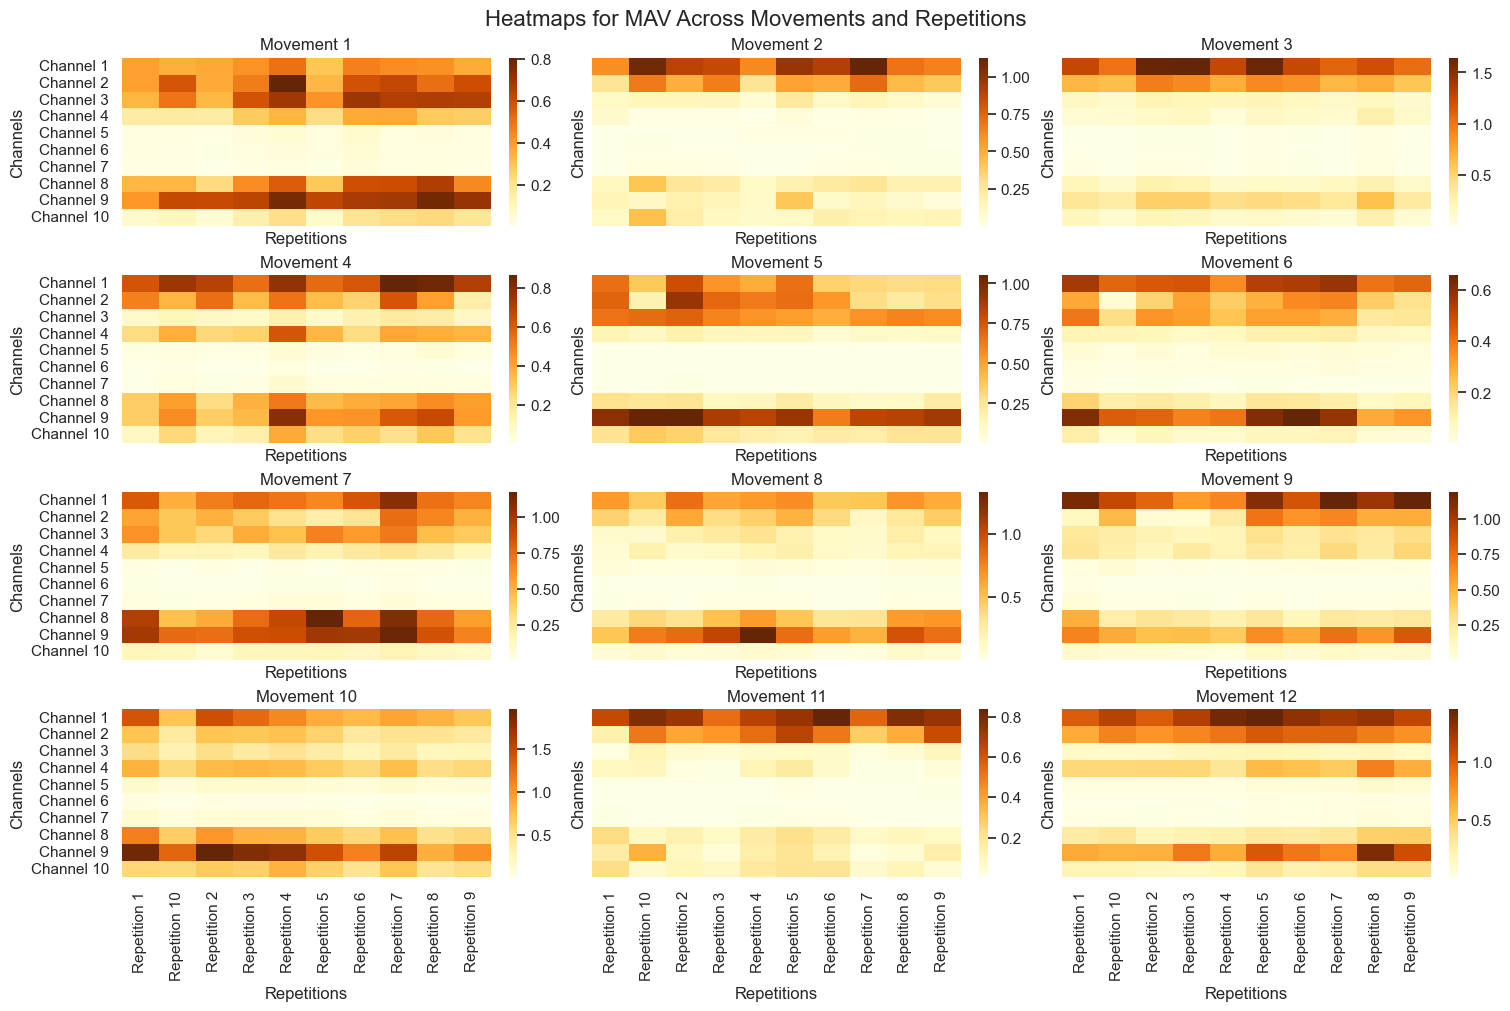

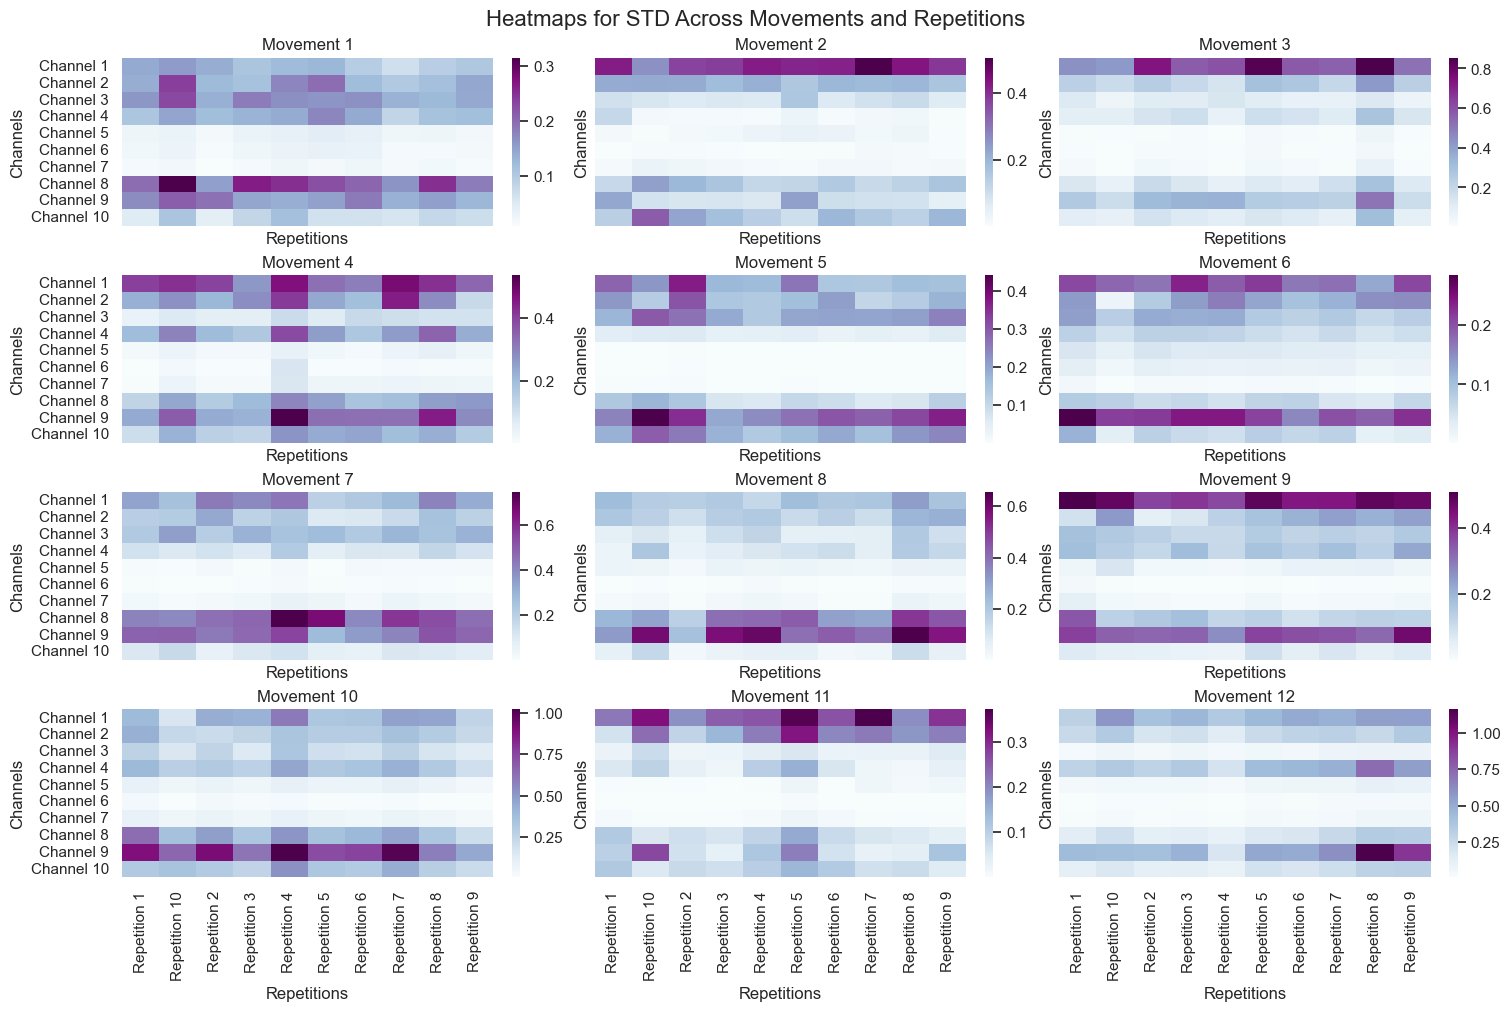

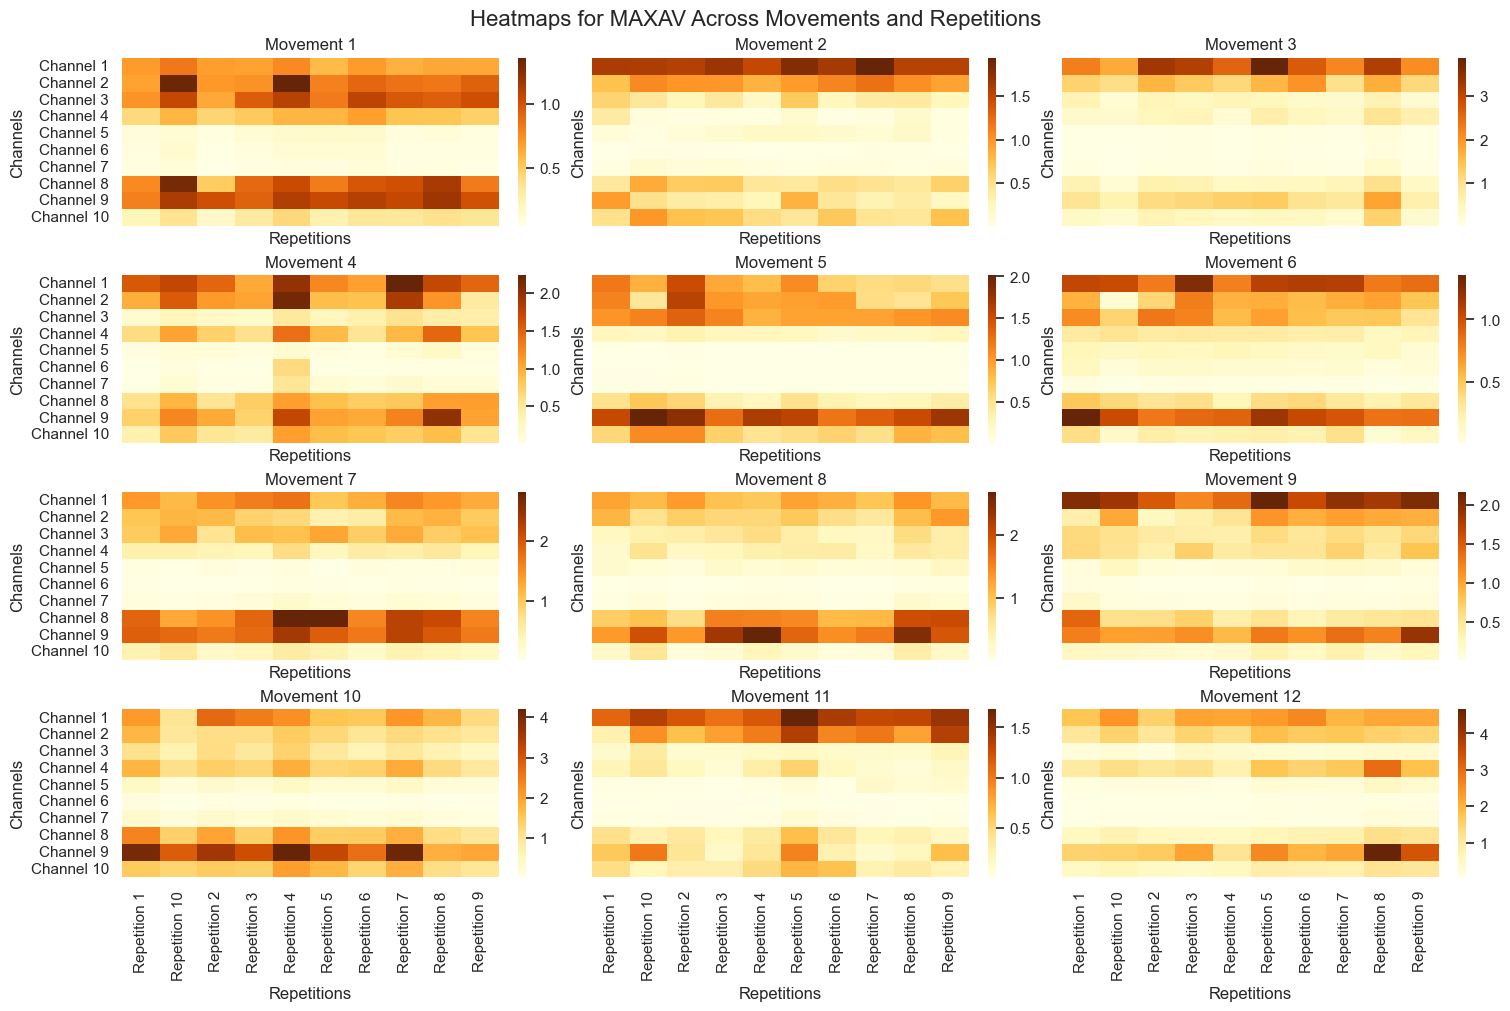

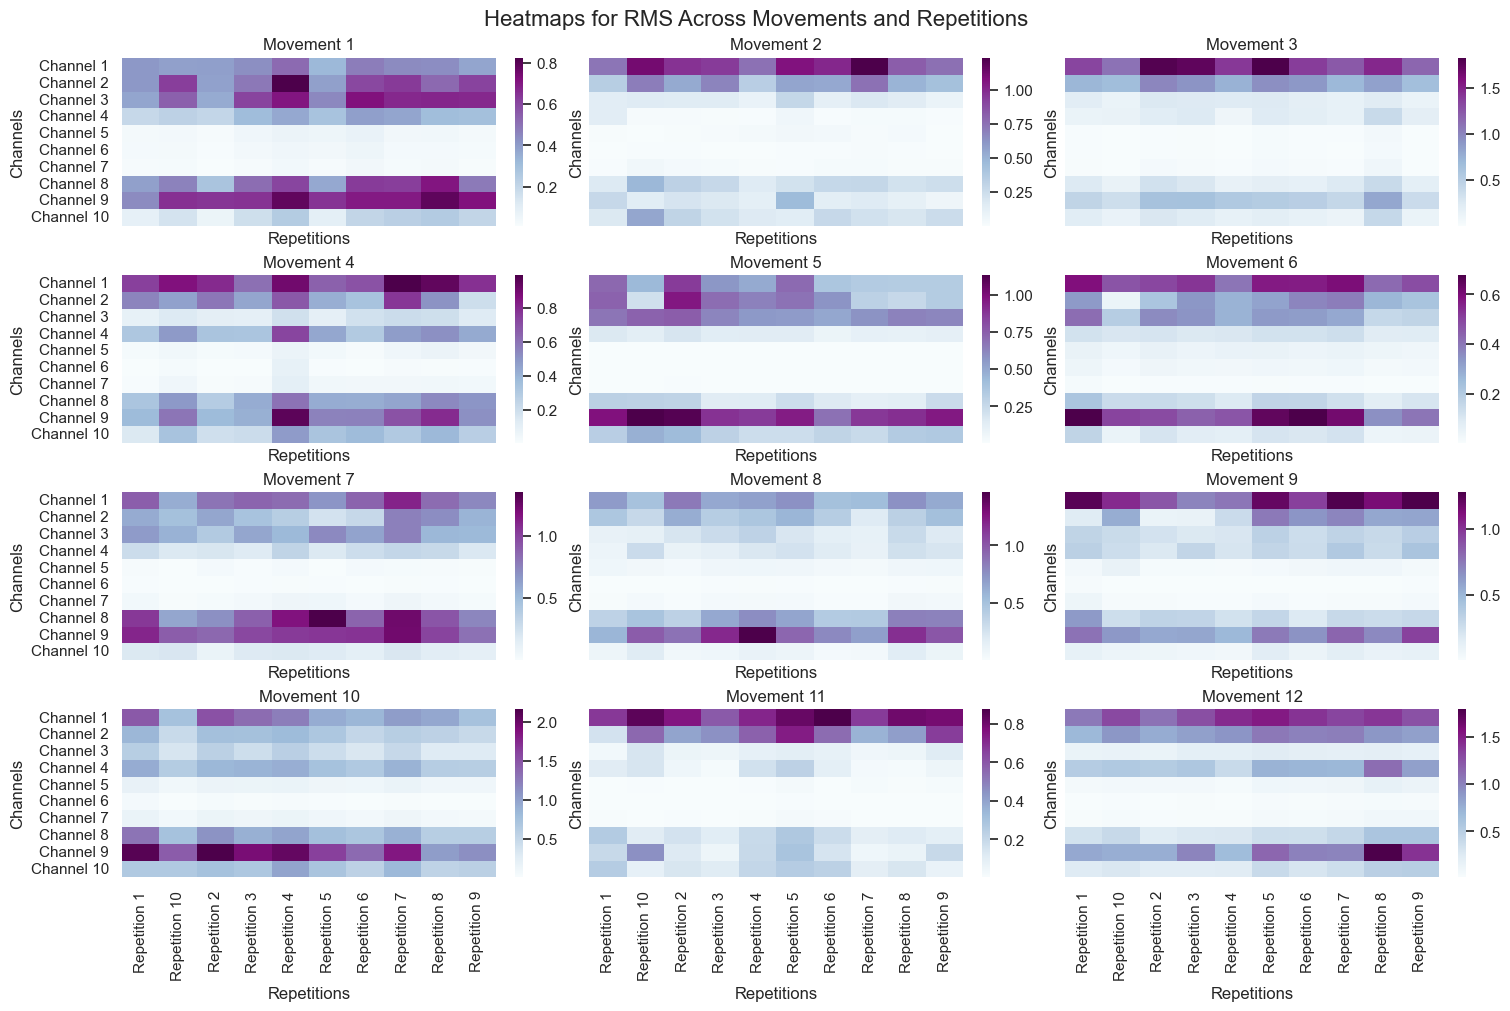

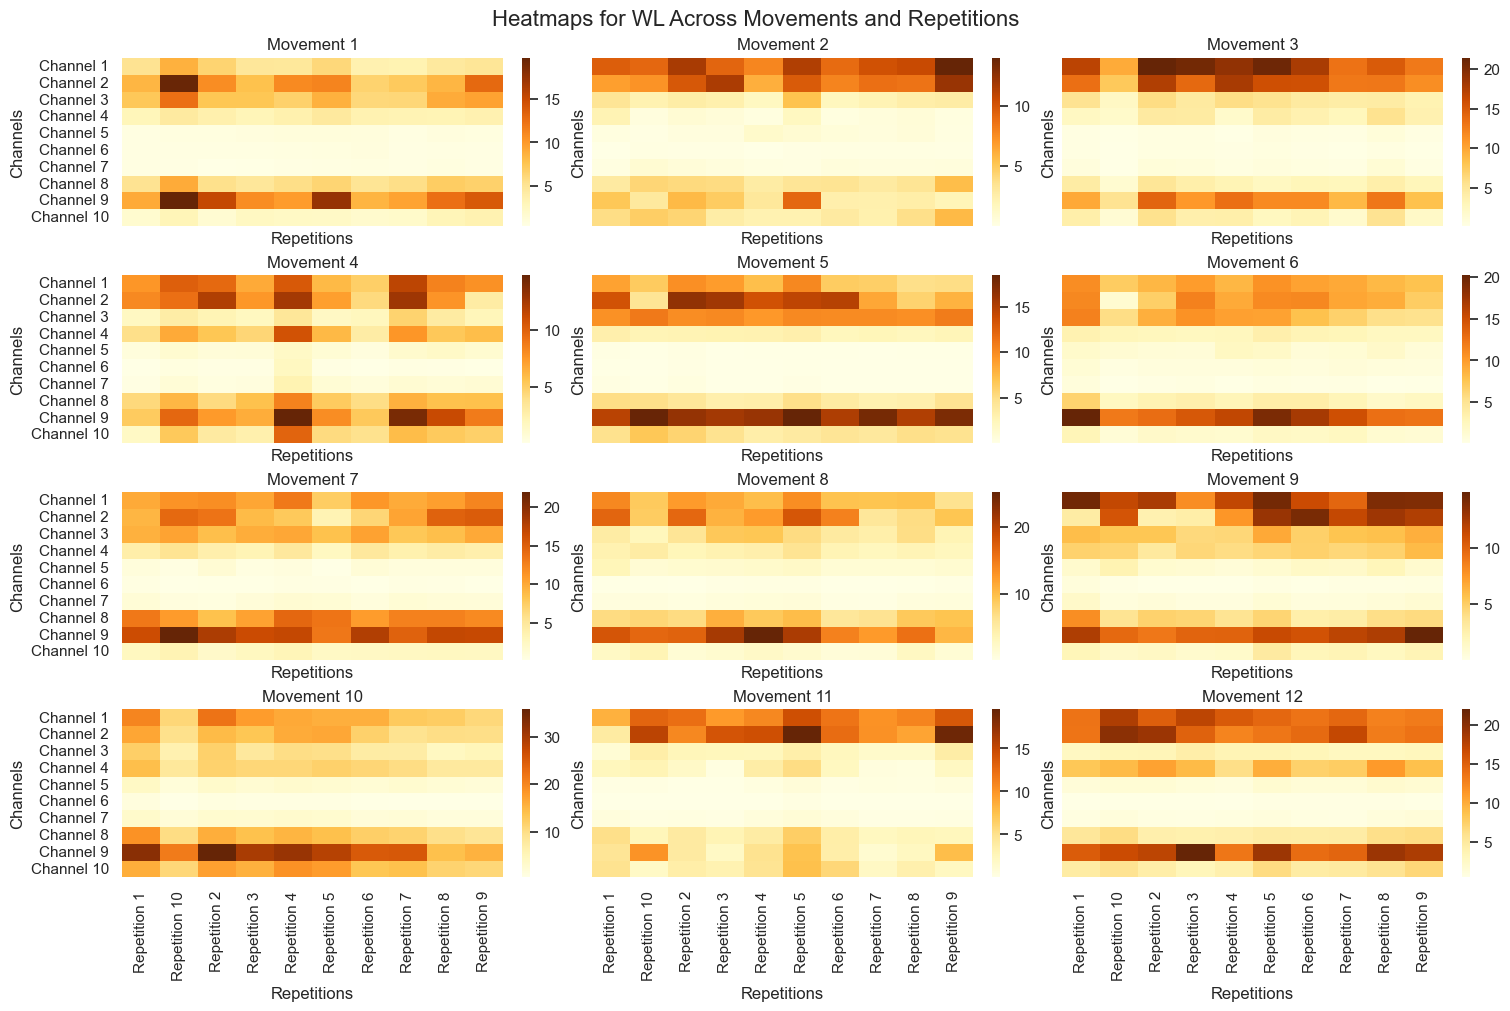

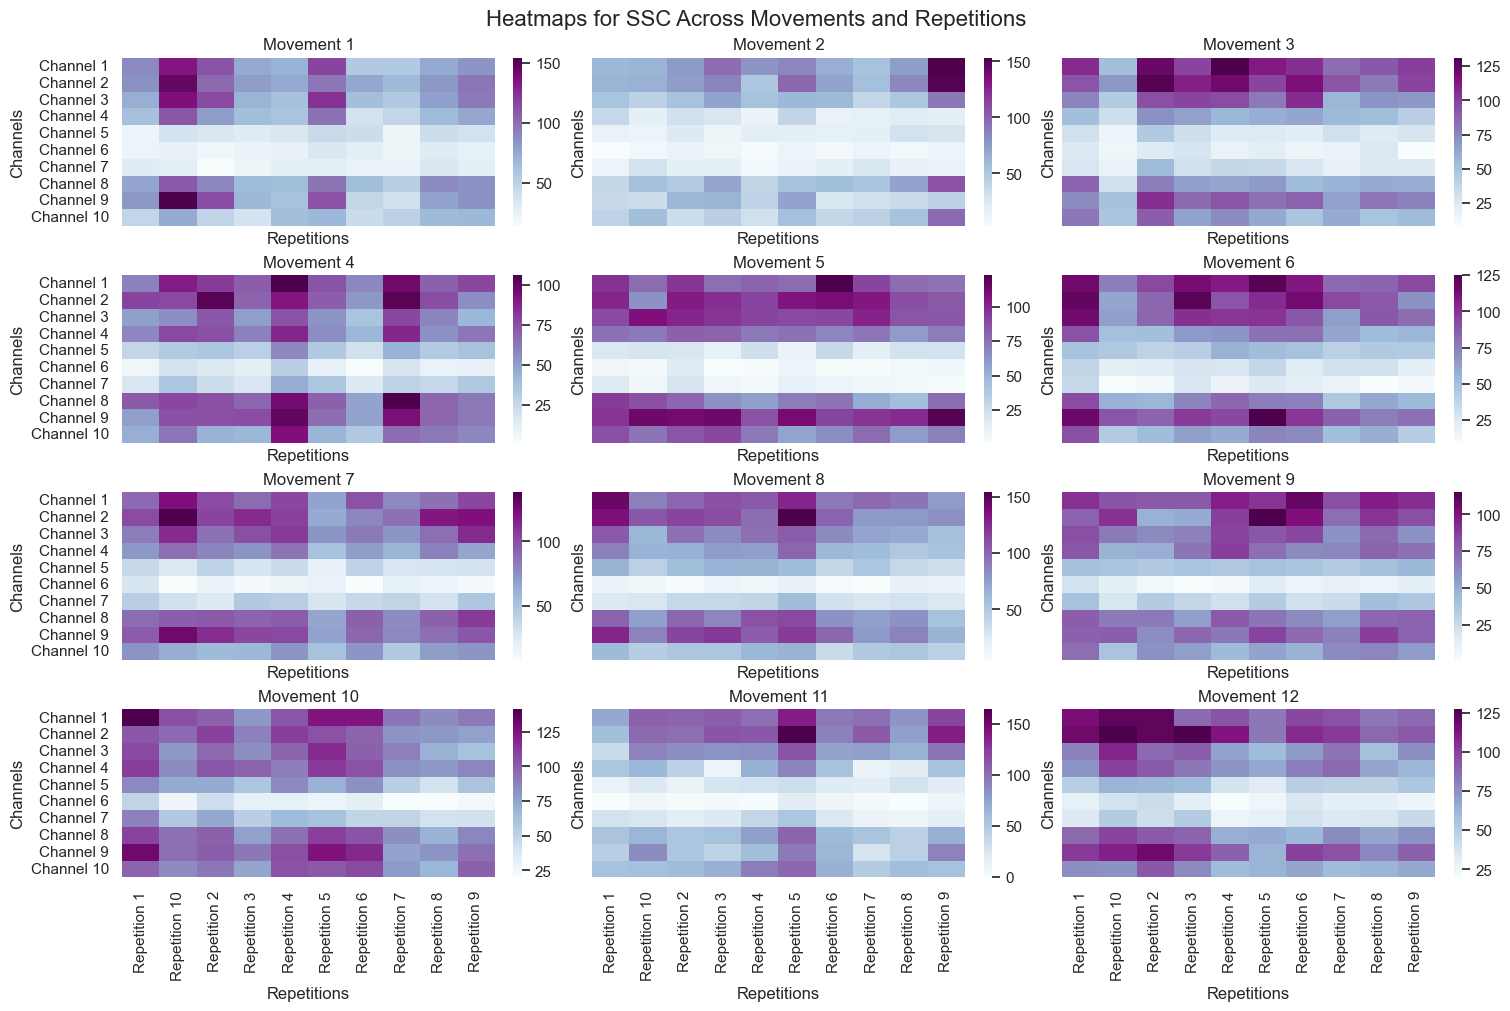

In [74]:


# Assuming `data_df` is your DataFrame organized as shown in the image.
# Columns are structured as "Channel X - FEATURE".

# List of features to plot (e.g., MAV, STD, etc.)


# Loop through each feature and create a separate figure
for i,feature in enumerate(features):
    # Filter columns corresponding to the current feature
    feature_columns = [col for col in data_df.columns if feature in col]
    
    # Prepare data for heatmaps
    n_channels = len(feature_columns)  # Number of channels for the feature
    data_array = np.zeros((n_movements, n_channels, n_repetitions))
    for movement_idx, movement in enumerate(movements):
        for repetition_idx, repetition in enumerate(repetitions):
            row_label = f"{movement} - {repetition}"
            if row_label in data_df.index:
                data_array[movement_idx, :, repetition_idx] = data_df.loc[row_label, feature_columns].values
    
    # Create heatmaps for the current feature
    fig, axes = plt.subplots(4, 3, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
    axes = axes.ravel()
    
    for movement_idx in range(n_movements):
        sns.heatmap(data_array[movement_idx, :, :], ax=axes[movement_idx], 
                    xticklabels=repetitions, yticklabels=[f"Channel {i+1}" for i in range(n_channels)],
                    cbar= True,cmap = "YlOrBr" if i%2 == 0 else "BuPu" )#(movement_idx == n_movements - 1))  # Add colorbar only for the last plot
        axes[movement_idx].set_title(f"Movement {movement_idx + 1}")
        axes[movement_idx].set_xlabel("Repetitions")
        axes[movement_idx].set_ylabel("Channels")
    
    # Global title for the feature
    plt.suptitle(f"Heatmaps for {feature} Across Movements and Repetitions", fontsize=16)
    plt.show()



In [76]:
df.describe()

,Channel 1 - MAV,Channel 2 - MAV,Channel 3 - MAV,Channel 4 - MAV,Channel 5 - MAV,Channel 6 - MAV,Channel 7 - MAV,Channel 8 - MAV,Channel 9 - MAV,Channel 10 - MAV,...,Channel 2 - SSC,Channel 3 - SSC,Channel 4 - SSC,Channel 5 - SSC,Channel 6 - SSC,Channel 7 - SSC,Channel 8 - SSC,Channel 9 - SSC,Channel 10 - SSC,Label
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.785619,0.508316,0.284548,0.241694,0.032901,0.011273,0.023714,0.357725,0.656261,0.194577,...,94.875000,80.016667,65.408333,37.100000,17.125000,29.441667,74.458333,83.891667,63.175000,6.500000
std,0.320491,0.223031,0.190132,0.204439,0.033472,0.009900,0.025724,0.248003,0.393956,0.157796,...,22.674742,20.265458,22.103080,16.515539,10.988583,15.079507,18.260439,25.086672,17.087842,3.466527
min,0.292367,0.042192,0.019993,0.004266,0.002517,0.002400,0.002432,0.068046,0.029552,0.025968,...,48.000000,34.000000,10.000000,10.000000,0.000000,2.000000,31.000000,27.000000,31.000000,1.000000
25%,0.546918,0.346419,0.140103,0.100431,0.008699,0.003601,0.006599,0.176404,0.401284,0.091435,...,79.000000,64.000000,55.000000,24.000000,8.000000,18.000000,61.000000,67.750000,51.000000,3.750000
50%,0.720820,0.507323,0.228013,0.173659,0.023009,0.007454,0.015893,0.271390,0.628614,0.151082,...,94.500000,81.500000,67.000000,35.000000,16.000000,28.000000,74.000000,86.000000,61.500000,6.500000
75%,1.010312,0.667349,0.410295,0.340772,0.043955,0.015328,0.029250,0.489101,0.854534,0.230097,...,110.000000,96.000000,80.000000,45.000000,26.000000,37.500000,88.250000,100.250000,73.000000,9.250000
max,1.640325,1.027265,0.707780,0.844596,0.163860,0.048744,0.133106,1.172185,1.952640,0.834444,...,164.000000,137.000000,113.000000,85.000000,50.000000,88.000000,113.000000,154.000000,107.000000,12.000000


# **5-FOLD CROSS-VALIDATION 20-20-60**

Validation Accuracy with best hyperparameters: 0.92
Validation F1-Score with best hyperparameters: 0.91
Best estimator: SVC(C=0.1, kernel='linear')
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy with best hyperparameters: 0.96
Test F1-Score with best hyperparameters: 0.96


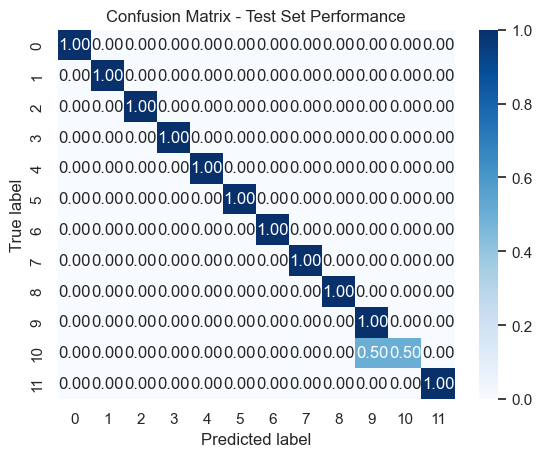

In [92]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

seed = np.random.seed(32)

# Step 1: Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.4, stratify=labels, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

# Step 2: Normalize the training, validation, and test data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)

# Step 3: Define a parameter grid for GridSearchCV
param_grid = {
    "C": [0.02, 0.05, 0.1, 0.15, 0.2],    # Regularization parameter
    "kernel": ['linear', 'rbf', 'poly'],  # Different kernels
    "gamma": ['scale', 'auto'],           # Kernel coefficient
}

# Step 4: Perform GridSearchCV on the validation set
grid = GridSearchCV(SVC(), param_grid, cv=5)  # Use 5-fold cross-validation
grid.fit(X_train_z, y_train)  # Train on training set

# Evaluate on validation set
y_val_pred = grid.predict(X_val_z)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')  # Weighted F1-score for imbalanced datasets
print(f"Validation Accuracy with best hyperparameters: {val_accuracy:.2f}")
print(f"Validation F1-Score with best hyperparameters: {val_f1:.2f}")

# Print the best hyperparameters and estimator
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Step 5: Final evaluation on the test set
y_test_pred = grid.predict(X_test_z)

# Calculate accuracy, F1-score, and confusion matrix on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred,average='weighted')  # Weighted F1-score for test set
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")

print(f"Test Accuracy with best hyperparameters: {test_accuracy:.2f}")
print(f"Test F1-Score with best hyperparameters: {test_f1:.2f}")

# Step 6: Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix - Test Set Performance")
plt.show()


# **FEATURE EXTRACTION : K-BEST FEATURES**

Using best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} and 60 features
Estimated mutual information between each feature and the target:
 [0.5359819  0.25032295 0.70255996 1.00433219 0.81274651 0.59551786
 0.68894208 0.66458144 0.93031916 0.53944154 0.71606175 0.32124369
 0.76621411 0.83105997 0.56910281 0.53988375 0.71502315 0.79767008
 0.90612764 0.54624204 0.91175062 0.45666446 0.66447236 0.864963
 0.52752182 0.53378821 0.67833423 0.73096672 0.77897553 0.67913347
 0.60994221 0.31682592 0.74834315 0.96981362 0.7361247  0.57171463
 0.77494679 0.76282683 0.95506166 0.58372971 0.53190088 0.15363936
 0.78249637 0.80645952 0.90873491 0.72087167 0.71949221 0.77452812
 0.67543404 0.56466694 0.24325533 0.07723118 0.25559798 0.29134506
 0.5947899  0.41242243 0.37103839 0.13655828 0.42701333 0.20029652]

Validation accuracy with 1 best features: 0.3333333333333333
Validation accuracy with 2 best features: 0.4166666666666667
Validation accuracy with 3 best features: 0.4166

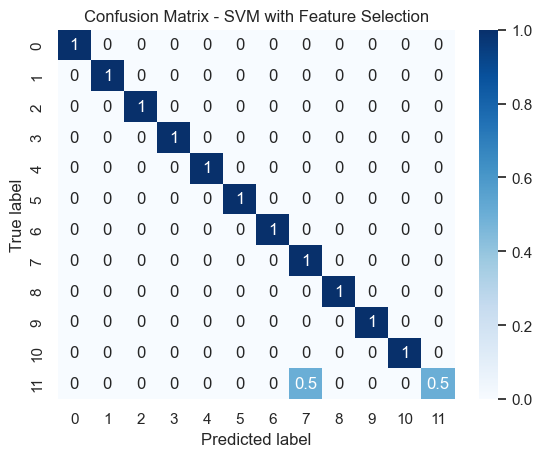

In [95]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


max_k = 60
# Step 1: Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.4, stratify=labels, random_state=np.random.seed(32))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

# Step 2: Normalize the training and validation data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)

print(f"Using best hyperparameters: {grid.best_params_} and {max_k} features")
# Step 5: Feature selection using mutual information on the training set
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

results = {}
for k in range(1, X_train_z.shape[1] + 1):  # Iterate over 1 to all features
    # Select the top k features based on mutual information scores
    k_best = SelectKBest(mutual_info_classif, k=k)
    k_best.fit(X_train_z, y_train)

    # Transform the training and validation datasets to include only selected features
    X_train_best = k_best.transform(X_train_z)
    X_val_best = k_best.transform(X_val_z)

    # Retrain the SVM model with the selected features and best hyperparameters
    clf = SVC(**grid.best_params_)
    clf.fit(X_train_best, y_train)

    # Predict on the validation set
    y_val_pred = clf.predict(X_val_best)

    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy with {k} best features: {val_accuracy}")
    results[str(k)] = val_accuracy

# Step 6: Find the optimal number of features based on the validation set
max_k, max_accuracy = max(results.items(), key=lambda item: item[1])
max_k = int(max_k)  # Convert to integer
print(f"The best k is {max_k} with validation accuracy of {max_accuracy:.2f}")

# Step 7: Evaluate final model on the test set using the best features
k_best = SelectKBest(mutual_info_classif, k=max_k)
k_best.fit(X_train_z, y_train)

X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

clf = SVC(**grid.best_params_)
clf.fit(X_train_best, y_train)

y_test_pred = clf.predict(X_test_best)

# Calculate test accuracy and confusion matrix
test_accuracy = accuracy_score(y_test, y_test_pred)
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")

print(f"Final test accuracy with {max_k} best features: {test_accuracy}")

# Step 8: Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix - SVM with Feature Selection")
plt.show()


# **DIMENSION REDUCTION : PCA**

Number of components: 1, Validation Accuracy: 0.2917
Number of components: 2, Validation Accuracy: 0.5833
Number of components: 3, Validation Accuracy: 0.5833
Number of components: 4, Validation Accuracy: 0.7083
Number of components: 5, Validation Accuracy: 0.7917
Number of components: 6, Validation Accuracy: 0.8333
Number of components: 7, Validation Accuracy: 0.8750
Number of components: 8, Validation Accuracy: 0.8750
Number of components: 9, Validation Accuracy: 0.9167
Number of components: 10, Validation Accuracy: 0.9167
Number of components: 11, Validation Accuracy: 0.9167
Number of components: 12, Validation Accuracy: 0.9167
Number of components: 13, Validation Accuracy: 0.9167
Number of components: 14, Validation Accuracy: 0.9167
Number of components: 15, Validation Accuracy: 0.9167
Number of components: 16, Validation Accuracy: 0.9167
Number of components: 17, Validation Accuracy: 0.9167
Number of components: 18, Validation Accuracy: 0.9167
Number of components: 19, Validation 

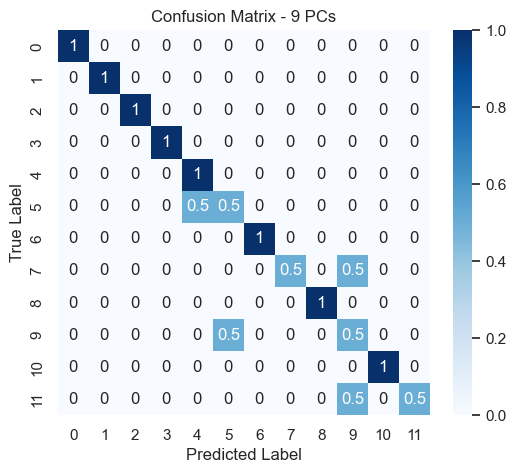

In [98]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.4, stratify=labels, random_state= np.random.seed(32))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=np.random.seed(32))

# Step 2: Standardize the Data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)

# Step 3: Apply PCA and Iterate Over Principal Components
pca = PCA()
pca.fit(X_train_z)  # Fit PCA on the training set

results = {}
best_accuracy = 0
best_n_components = 0

for n_components in range(1, X_train_z.shape[1] + 1):  # From 1 to max PCs
    # Reduce dimensions using the top n_components
    pca_current = PCA(n_components=n_components)
    X_train_pca = pca_current.fit_transform(X_train_z)
    X_val_pca = pca_current.transform(X_val_z)

    # Step 4: Train the SVM Model with Predefined Best Hyperparameters
    best_params = {"C": 0.05, "kernel": "linear", "gamma": "scale"}
    clf = SVC(**best_params)
    clf.fit(X_train_pca, y_train)

    # Evaluate the model on validation set
    y_val_pred = clf.predict(X_val_pca)
    accuracy = accuracy_score(y_val, y_val_pred)

    # Store results
    results[n_components] = accuracy
    print(f"Number of components: {n_components}, Validation Accuracy: {accuracy:.4f}")

    # Update the best result
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = n_components

# Step 5: Display Best Results
print(f"\nBest validation accuracy: {best_accuracy:.4f} achieved with {best_n_components} components.")

# Step 6: Retrain Model on the Test Set Using Best n_components
pca_final = PCA(n_components=best_n_components)
X_train_pca_final = pca_final.fit_transform(X_train_z)
X_test_pca_final = pca_final.transform(X_test_z)

clf = SVC(**best_params)
clf.fit(X_train_pca_final, y_train)

y_test_pred = clf.predict(X_test_pca_final)

# Final Accuracy
final_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final test accuracy with {best_n_components} components: {final_accuracy:.4f}")

# Step 7: Confusion Matrix
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")
plt.figure(figsize=(6, 5))
sns.heatmap(confmat, annot=True, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {best_n_components} PCs")
plt.show()


# **BEST PRINCIPAL COMPONENTS**

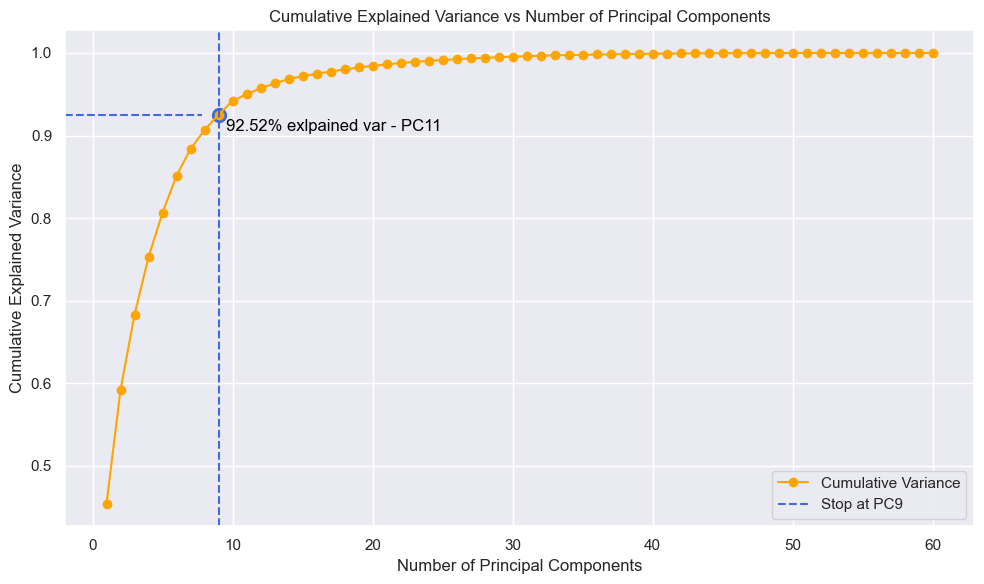

In [100]:
# Assuming 'dataset' is the original features (without labels)
# Step 1: Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Calculate Cumulative Explained Variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
pc_stop = 9  # Stop at PC11
variance_at_pc11 = cumulative_variance[pc_stop - 1]  # Variance explained at PC11

# Step 4: Plot Cumulative Variance with Red Curve Stopping at PC11
plt.figure(figsize=(10, 6))

# Plot the cumulative explained variance as orange dots
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='orange', label="Cumulative Variance")


# Vertical and horizontal line
plt.axvline(x=pc_stop, color='royalblue', linestyle='--', label=f"Stop at PC{pc_stop}")
plt.axhline(y=variance_at_pc11, xmin=0, xmax=pc_stop/len(cumulative_variance), color='royalblue', linestyle='--')
plt.scatter(pc_stop, variance_at_pc11, color='royalblue', s=100)  # Highlight the intersection point

# Annotate the percentage of variance explained
plt.text(pc_stop + 0.5, variance_at_pc11 - 0.02, f"{variance_at_pc11:.2%} exlpained var - PC11", fontsize=12, color='black')

# Customizations
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs Number of Principal Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

